# Boston Neighborhood Clustering Analysis

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
#import geocoder # import geocoder

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries imported.')


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

# Part I - Data Cleaning and Processing

In [2]:
website_url = requests.get('http://archive.boston.com/news/local/articles/2007/04/15/sixfigurezipcodes_city/').text
soup = BeautifulSoup(website_url,'lxml')
table = soup.find('table',{'width':'565'})
ths = table.find_all('th')

headings = [th.text.strip() for th in ths]
headings[0] = 'Zip_Code'
headings[1] = 'Neighborhood'

# Table Data is the originial zipcode and neighborhood name data pulled from the url.
Table_Data = []
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if len(tds) >1:
        if not tds:
            continue
        #print(tds)
        Zip_Code, Neighborhood = [td.text.strip() for td in tds[:2]]
        Table_Data.append([Zip_Code, Neighborhood])
    
Table_Data_Grouped = []
for row in Table_Data:
    entry = []

df = pd.DataFrame(Table_Data)
df.columns = headings[0:2] 

df = df[df.Neighborhood != 'Cambridge'] # This removes all Cambridge entries
df = df[df.Neighborhood != 'Somerville'] # This removes all Somerville entries
df = df.drop_duplicates(subset='Neighborhood', keep="first")

Zip_Code_Cambridge = ['02138', 
                      '02139', 
                      '02140', 
                      '02141', 
                      '02142']
Neighborhood_Cambridge = ['West Cambdrige / Harvard Square / Agassiz',
                          'Mid- Cambridge / Central / Cambridgeport',
                          'North Cambridge / Porter Square',
                          'East Cambridge / Wellington - Harrington',
                          'Kendall']

df2 = pd.DataFrame({'Zip_Code': Zip_Code_Cambridge,'Neighborhood':Neighborhood_Cambridge})

df = df.append(df2, ignore_index = True)



# This will introduce Latitiude and Longitude data into the table. 
zip_table = pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')

Zip = []

for i in range(zip_table.shape[0]):
    z = zip_table.ZIP[i]
    if len(str(z)) == 3:
        Zip.append('00'+str(z))
    if len(str(z)) == 4:
        Zip.append('0'+str(z))
    if len(str(z)) == 5:
        Zip.append(str(z))

zip_table['Zip_Code'] = Zip

zip_table.drop(columns = 'ZIP', inplace = True)

df_merged = pd.merge(df,zip_table, on = 'Zip_Code')
df = df_merged

df

,Zip_Code,Neighborhood,LAT,LNG
0,02108,Beacon Hill,42.357768,-71.064858
1,02109,Markets / Inner Harbor,42.367032,-71.050493
2,02110,Financial District / Wharves,42.361962,-71.047846
3,02111,Chinatown / Tufts-New England Medical Center,42.350518,-71.059077
4,02113,North End,42.365331,-71.055233
5,02114,West End / Back of the Hill,42.363174,-71.068646
6,02115,Fenway / East Fens / Longwood,42.337105,-71.105696
7,02116,Back Bay,42.350579,-71.076397
8,02118,South End,42.337582,-71.070482
9,02119,Roxbury,42.324029,-71.085017


In [3]:
CLIENT_ID = 'WQZ4C3RX1UX3YLTANCQFQ4XMOD0W5LSMRHJSTCGXJQ0VEX1L' # your Foursquare ID
CLIENT_SECRET = 'BX10JIX4Q0R3JACDMIQXFHINLCOXPUDWNWERJOCVFCGZRWX5' # your Foursquare Secret
VERSION = '20190722' # Foursquare API version

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Category']
    
    return(nearby_venues)

LIMIT = 100

radius = 500

boston_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['LAT'],
                                   longitudes=df['LNG']
                                  )

boston_venues.head()

,Neighborhood,Latitude,Longitude,Venue,Venue_Latitude,Venue_Longitude,Category
0,Beacon Hill,42.357768,-71.064858,Frog Pond,42.356134,-71.065672,Lake
1,Beacon Hill,42.357768,-71.064858,Boston Common,42.355487,-71.064882,Park
2,Beacon Hill,42.357768,-71.064858,Boston Athenaeum,42.357481,-71.061838,Library
3,Beacon Hill,42.357768,-71.064858,No. 9 Park,42.357540,-71.063193,French Restaurant
4,Beacon Hill,42.357768,-71.064858,Florina,42.359375,-71.063219,Pizza Place


# Part II - Analysis of Coffee Shop Adjacent Venues In Boston Neighborhoods

In [4]:
bakery_words = ['Bakery', 
              'Coffee', 
              'Dessert',  
              'Pastry', 
              'Café', 
              'Tea',  
              'Bagel', 
              'Donut', 
              'Cupcake' 
               ]

# Build each dataframe that has a bakery related word contained in its category
bakery_word_dfs = []
for word in bakery_words:
    bakery_word_dfs.append(boston_venues[boston_venues['Category'].str.contains(word)])

# Build the master dataframe that concatenates each of the food_word dataframes    
boston_food_venues = pd.concat(bakery_word_dfs)
boston_food_venues.reset_index(inplace = True)

boston_food_venues.head()


,index,Neighborhood,Latitude,Longitude,Venue,Venue_Latitude,Venue_Longitude,Category
0,35,Beacon Hill,42.357768,-71.064858,Tatte Bakery & Cafe,42.357904,-71.070439,Bakery
1,128,Markets / Inner Harbor,42.367032,-71.050493,Bova's Bakery,42.365194,-71.055443,Bakery
2,145,Markets / Inner Harbor,42.367032,-71.050493,Parziale's Bakery,42.365367,-71.055709,Bakery
3,228,Chinatown / Tufts-New England Medical Center,42.350518,-71.059077,Great Taste Bakery & Restaurant,42.351291,-71.060165,Bakery
4,230,Chinatown / Tufts-New England Medical Center,42.350518,-71.059077,Tatte,42.353111,-71.057117,Bakery


In [5]:
# This will one hot encode across all of the possible bakery_word venue categories. 

boston_onehot = pd.get_dummies(boston_food_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_food_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot = boston_onehot.groupby('Neighborhood').sum()

boston_onehot_merged = pd.merge(df,boston_onehot, on = 'Neighborhood')

boston_onehot_merged

,Zip_Code,Neighborhood,LAT,LNG,Bagel Shop,Bakery,Bubble Tea Shop,Café,Coffee Shop,Cupcake Shop,Dessert Shop,Donut Shop,Pastry Shop,Tea Room
0,02108,Beacon Hill,42.357768,-71.064858,0,1,0,0,4,0,1,0,0,0
1,02109,Markets / Inner Harbor,42.367032,-71.050493,0,2,0,2,1,0,1,0,1,0
2,02110,Financial District / Wharves,42.361962,-71.047846,0,0,0,0,2,0,0,0,0,0
3,02111,Chinatown / Tufts-New England Medical Center,42.350518,-71.059077,0,6,1,4,5,0,2,0,0,1
4,02113,North End,42.365331,-71.055233,0,5,0,3,2,0,1,0,1,0
5,02114,West End / Back of the Hill,42.363174,-71.068646,1,0,0,4,2,0,0,2,0,0
6,02115,Fenway / East Fens / Longwood,42.337105,-71.105696,1,0,0,2,3,0,0,2,0,0
7,02116,Back Bay,42.350579,-71.076397,1,2,0,2,2,1,1,0,0,0
8,02118,South End,42.337582,-71.070482,0,1,0,1,1,0,0,1,0,0
9,02120,Roxbury Crossing,42.332090,-71.096545,0,0,0,0,0,0,0,3,0,0


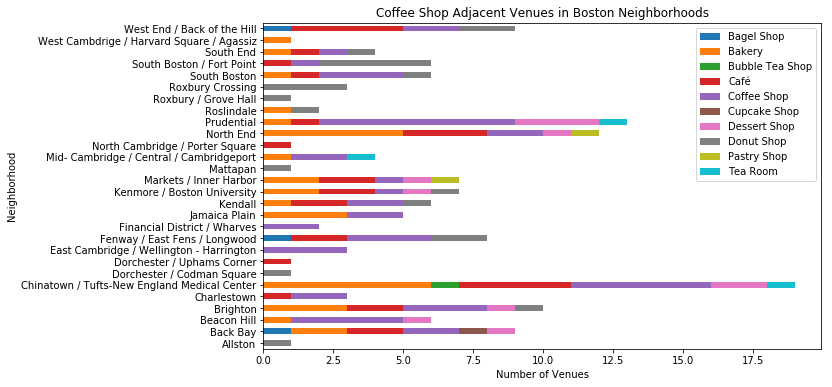

In [6]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

boston_onehot.plot(kind='barh', figsize=(10, 6), stacked = True)

plt.title('Coffee Shop Adjacent Venues in Boston Neighborhoods')
plt.ylabel('Neighborhood')
plt.xlabel('Number of Venues')

plt.show()

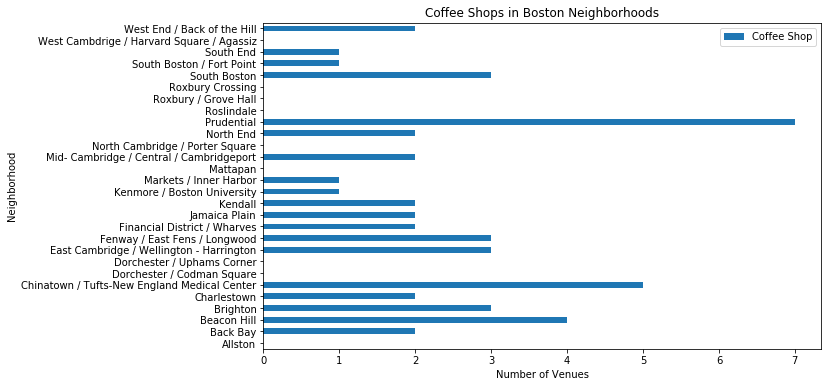

In [7]:
boston_onehot_coffee = boston_onehot[['Coffee Shop']]
boston_onehot_coffee

boston_onehot_coffee.plot(kind='barh', figsize=(10, 6), stacked = True)

plt.title('Coffee Shops in Boston Neighborhoods')
plt.ylabel('Neighborhood')
plt.xlabel('Number of Venues')

plt.show()

# Part III - Clustering Analysis of Boston Neighborhoods

In the following I will do a cluster analysis on Boston neighborhods across all venues types, to see which nrighborhoods are similar to the ones above which support a robust coffee shop and bakery scene.

In [8]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 9

indicators = ['st', 'nd', 'rd']

# First I will create the one hot dataframe for all venues.  

boston_onehot = pd.get_dummies(boston_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot = boston_onehot.groupby('Neighborhood').sum()

boston_onehot_merged = pd.merge(df,boston_onehot, on = 'Neighborhood')

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_onehot_merged['Neighborhood']


for ind in np.arange(boston_onehot.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_onehot.iloc[ind, :],num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue
0,Beacon Hill,Rental Car Location,Spa,Nightclub,Donut Shop,Bar,Liquor Store,Chinese Restaurant,Thrift / Vintage Store,Smoke Shop
1,Markets / Inner Harbor,American Restaurant,Spa,Gym,Boutique,Cosmetics Shop,Gym / Fitness Center,Hotel,New American Restaurant,Seafood Restaurant
2,Financial District / Wharves,American Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Plaza,Italian Restaurant,Playground,Steakhouse,Hotel
3,Chinatown / Tufts-New England Medical Center,Pub,Pizza Place,Bank,Bakery,Coffee Shop,Chinese Restaurant,Bus Station,Dry Cleaner,Café
4,North End,Historic Site,Park,Food Truck,Food & Drink Shop,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant


In [49]:
# set number of clusters
kclusters = 3

boston_grouped_clustering = boston_onehot#.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)

# add clustering labels
boston_onehot.drop('Cluster_Labels',1,inplace = True)
boston_onehot.insert(0,'Cluster_Labels', kmeans.labels_)


boston_merged = pd.merge(df,boston_onehot, on = 'Neighborhood')

neighborhoods_venues_sorted.drop('Cluster_Labels',1, inplace = True)
neighborhoods_venues_sorted.insert(0,'Cluster_Labels',kmeans.labels_)



[0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 1 0 0 0 0 0 0 0 0 1 0]


In [24]:
# create map
address = 'Boston, MA'

geolocator = Nominatim(user_agent="Boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['LAT'], boston_merged['LNG'], boston_merged['Neighborhood'], boston_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [51]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster_Labels'] == 0, neighborhoods_venues_sorted.columns[[1]+[2]+[3]+[4]]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Beacon Hill,Rental Car Location,Spa,Nightclub
3,Chinatown / Tufts-New England Medical Center,Pub,Pizza Place,Bank
4,North End,Historic Site,Park,Food Truck
5,West End / Back of the Hill,Pizza Place,Convenience Store,Gym
7,Back Bay,Caribbean Restaurant,Playground,Park
8,South End,Bowling Alley,Italian Restaurant,Hotel
9,Roxbury,Pub,Pizza Place,Breakfast Spot
10,Roxbury Crossing,Coffee Shop,Pizza Place,Park
11,Roxbury / Grove Hall,Coffee Shop,Sandwich Place,Donut Shop
12,Dorchester / Fields Corner,Boat or Ferry,Harbor / Marina,Aquarium


In [ ]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster_Labels'] == 1, neighborhoods_venues_sorted.columns[[1]+[2]+[3]+[4]]]

In [ ]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster_Labels'] == 2, neighborhoods_venues_sorted.columns[[1]+[2]+[3]+[4]]]